## Generating visualizations from shapefile and pandas dataframe dynamically

### Import Modules

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from descartes import PolygonPatch
import seaborn
from shapely.geometry import MultiPolygon, shape
from fiona import collection
import fiona
import pandas
import random
import datetime

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
seaborn.set()

### Import Data

In [3]:
data = pandas.read_excel('/users/danielcorcoran/desktop/github_repos/python_nb_visualization/data/lgaprofiles15.xlsx',
                        sheet_name = "LGAs")

lga_code_column = 'LGA Code'

In [4]:
print(data.columns)
print(data.shape)

Index(['LGA Name', 'LGA Code', 'Departmental Region', 'Departmental Area',
       'Area of LGA (km2)', 'Most populous community', 'Distance to Melbourne',
       'Travel time to Melbourne', 'Remoteness area', 'Commercial land use',
       ...
       'Average patient contribution for prescriptions',
       'Average patient contribution for prescriptions (rank)',
       'HACC clients aged less than 65 years per 1,000 target population',
       'HACC clients aged less than 65 years per 1,000 target population (rank)',
       'HACC clients aged 65 years and over per 1,000 target population',
       'HACC clients aged 65 years and over per 1,000 target population (rank)',
       'Clients that received Alcohol & Drug Treatment Services per 1,000 population',
       'Clients that received Alcohol & Drug Treatment Services per 1,000 population (rank)',
       'Registered mental health clients per 1,000 population',
       'Registered mental health clients per 1,000 population (rank)'],
      d

### Manipulate into desired format
- Desired format for this code is one lga code column, the remaining columns will be numeric measures
- The numeric measures will be converted into bins and indexed so that they can be matched back to colour coding bands

In [5]:
data2 = data[data["LGA Name"] != 'Victoria']
data3 = data2.dropna(how = "any", axis = 1)

In [6]:
ranks = [column for column in data3.columns if 'rank' in column]

In [7]:
ranks.append(lga_code_column)

In [8]:
data4 = data3[ranks]

In [9]:
data5 = data4[[
    'LGA Code', 'People with low English proficiency (rank)',
    'People who believe multiculturalism makes life better (rank)'
]]

### Store original columns

In [10]:
original_columns = list(data5.columns)
print(original_columns)

['LGA Code', 'People with low English proficiency (rank)', 'People who believe multiculturalism makes life better (rank)']


### Store process columns

In [11]:
process_columns = [column for column in original_columns if column != lga_code_column]
print(process_columns)

['People with low English proficiency (rank)', 'People who believe multiculturalism makes life better (rank)']


### Create bin columns
- Two bin columns created for each column in `process_columns`
- One bin column with labels and one with index of the label 0-4
- Bin index labels to be mapped to colour indices later on

In [12]:
bins = 5
bins_index_suffix = '_bins_index'
bins_name_suffix = '_bins_name'

for column in process_columns:

    data5[column + bins_index_suffix] = pandas.qcut(
        data5[column], q=bins, labels=list(range(bins)))

    data5[column + bins_name_suffix] = pandas.qcut(data5[column], q=bins)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

In [13]:
data5.head()

,LGA Code,People with low English proficiency (rank),People who believe multiculturalism makes life better (rank),People with low English proficiency (rank)_bins_index,People with low English proficiency (rank)_bins_name,People who believe multiculturalism makes life better (rank)_bins_index,People who believe multiculturalism makes life better (rank)_bins_name
0,20110.0,32.0,11.0,1,"(16.6, 32.2]",0,"(0.999, 16.6]"
1,20260.0,63.0,53.0,3,"(47.8, 63.4]",3,"(47.8, 63.4]"
2,20570.0,44.0,35.0,2,"(32.2, 47.8]",2,"(32.2, 47.8]"
3,20660.0,26.0,24.0,1,"(16.6, 32.2]",1,"(16.6, 32.2]"
4,20740.0,39.0,46.0,2,"(32.2, 47.8]",2,"(32.2, 47.8]"


### Import Shapefile and manipulate

In [14]:
shapepath = '/users/danielcorcoran/Desktop/github_repos/python_nb_data_spatial/data/LGA_ABS_16/LGA_2016_AUST.shp'

In [15]:
multipolygon = MultiPolygon([
    shape(p['geometry']).simplify(tolerance=0.05)
    for p in fiona.open(shapepath) if p['geometry'] is not None
    and p['properties']['STE_NAME16'] == 'Victoria'
])

### Set Colour Dictionary

In [16]:
cols5band = {
    'BrBg': ['#a6611a', '#dfc27d', '#f5f5f5', '#80cdc1', '#018571'],
    'PiYG': ['#d01c8b', '#f1b6da', '#f7f7f7', '#b8e186', '#4dac26'],
    'PRGn': ['#7b3294', '#c2a5cf', '#f7f7f7', '#a6dba0', '#008837'],
    'PuOr': ['#7b3294', '#c2a5cf', '#f7f7f7', '#a6dba0', '#008837'],
    'RdBu': ['#ca0020', '#f4a582', '#f7f7f7', '#92c5de', '#0571b0'],
    'RdGy': ['#ca0020', '#f4a582', '#ffffff', '#bababa', '#404040'],
    'RdYlBu': ['#d7191c', '#fdae61', '#ffffbf', '#abd9e9', '#2c7bb6'],
    'RdYlGn': ['#d7191c', '#fdae61', '#ffffbf', '#a6d96a', '#1a9641'],
    'Spectral': ['#d7191c', '#fdae61', '#ffffbf', '#abdda4', '#2b83ba'],
    'PuRd': ['#f1eef6', '#d7b5d8', '#df65b0', '#dd1c77', '#980043'],
    'RdPu': ['#feebe2', '#fbb4b9', '#f768a1', '#c51b8a', '#7a0177'],
    'YlGn': ['#ffffcc', '#c2e699', '#78c679', '#31a354', '#006837'],
    'YlGnBu': ['#ffffcc', '#a1dab4', '#41b6c4', '#2c7fb8', '#253494'],
    'YlOrRd': ['#ffffb2', '#fecc5c', '#fd8d3c', '#f03b20', '#bd0026']
}

In [17]:
# Set the colour key
key = 'RdYlBu'
colours = cols5band[key]

In [18]:
colours

['#d7191c', '#fdae61', '#ffffbf', '#abd9e9', '#2c7bb6']

### Figure Settings

In [19]:
export_path = '/users/danielcorcoran/desktop/github_repos/python_nb_visualization/seaborn_exports/'
border_colour = 'black'
fig_width = 16
fig_height = 12
linewidth = 0.22
alpha = 1
rev_colours = False

#####################################

if rev_colours == True:
    colours = list(reversed(colours))

### Generate, plot and save

In [20]:
aus_collection = fiona.Collection(shapepath, 'r')

In [21]:
vic_collection = [pol for pol in aus_collection 
                  if pol['geometry'] is not None and pol['properties']['STE_NAME16'] == 'Victoria']

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['Heltevitica'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


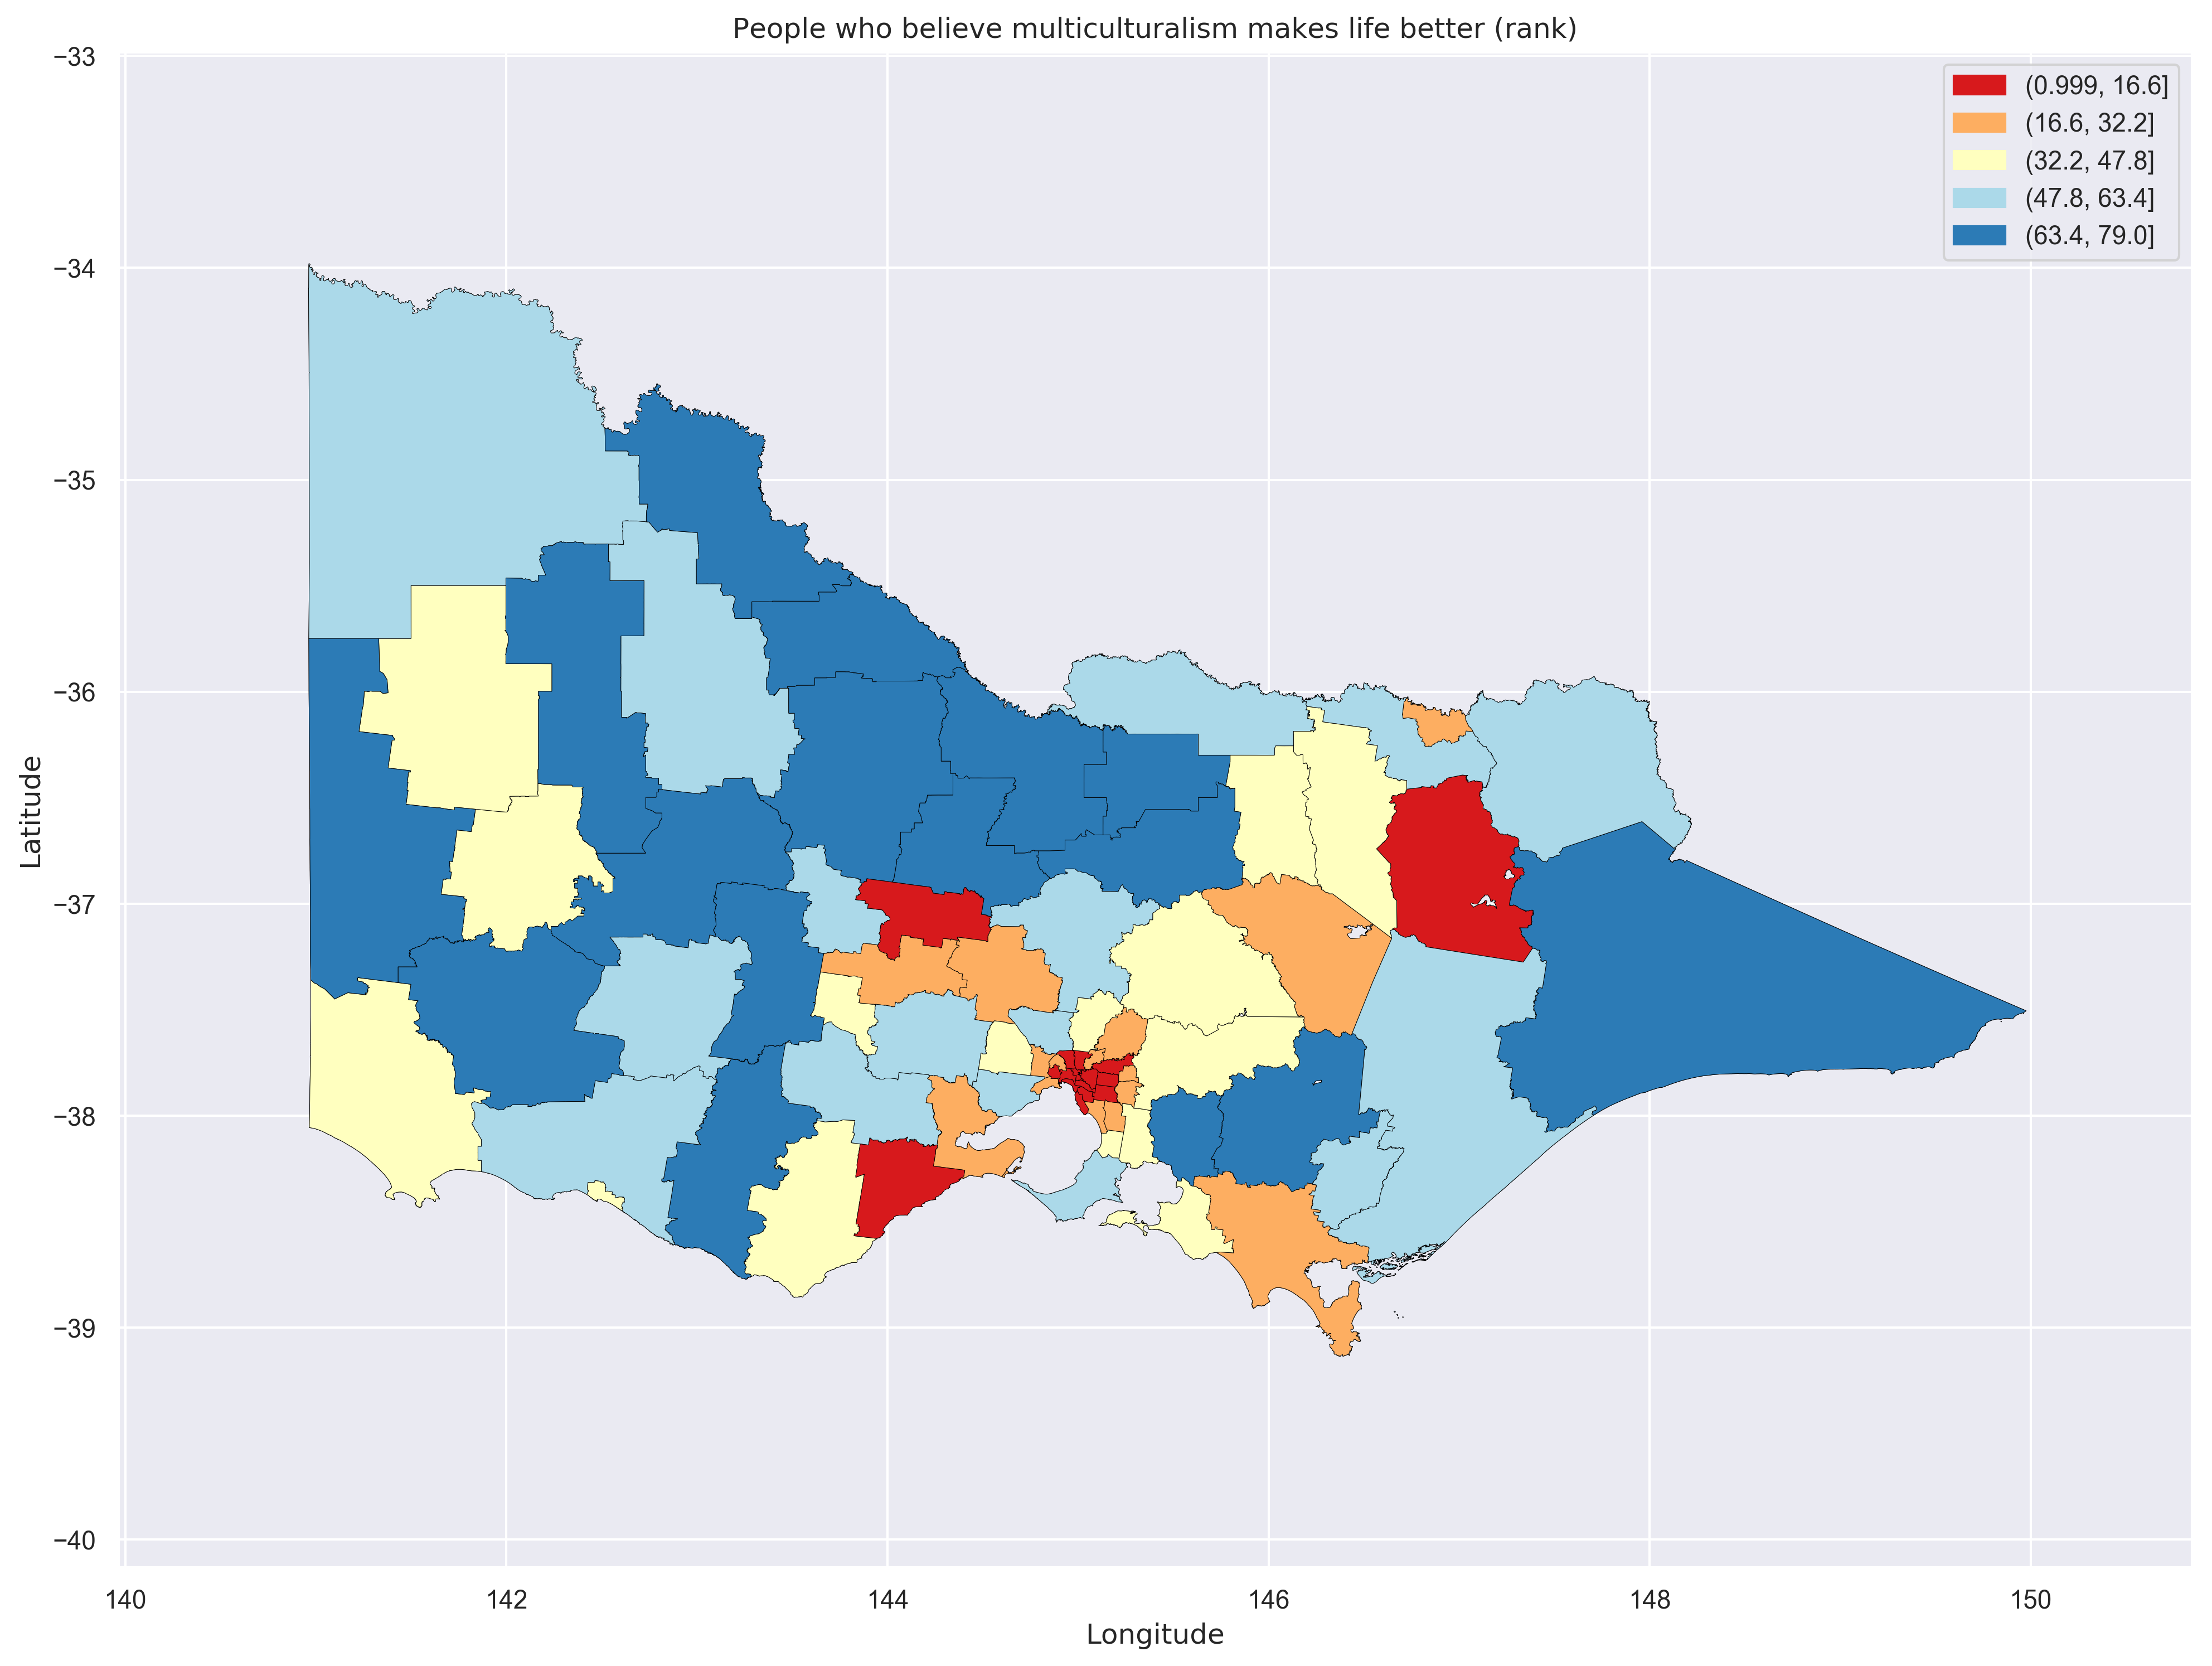

In [22]:
for column in process_columns:

    bin_col_name = column + bins_name_suffix
    bin_index_col_name = column + bins_index_suffix
    
    # Create figure
    fig = plt.figure(1, figsize=(fig_width, fig_height), dpi=300)

    ax = fig.add_subplot(111)
    
    # Build chart
    for pol in vic_collection:

        lga_code = float(pol['properties']['LGA_CODE16'])
        if lga_code in list(data5['LGA Code']):

            row = data5[data5[lga_code_column] == lga_code]
            row2 = row.reset_index(drop=True)
            colour_code = row2.loc[0, bin_index_col_name]
            shape_colour = colours[colour_code]

            ax.add_patch(
                PolygonPatch(
                    pol['geometry'],
                    fc=shape_colour,
                    ec=border_colour,
                    linewidth=linewidth,
                    alpha=alpha))

    # Set x/y axes
    xMin, yMin, xMax, yMax = multipolygon.bounds
    offset = 1
    ax.set_xlim(xMin + -offset, xMax + offset)
    ax.set_ylim(yMin - offset, yMax + offset)

    # Set text attributes
    font = {'fontname': 'Heltevitica'}
    ax.set_xlabel('Longitude', **font)
    ax.set_ylabel('Latitude', **font)
    ax.set_title(column, **font)

    # Create Legend
    data6 = data5.drop_duplicates(subset = [bin_index_col_name]).sort_values(bin_index_col_name)
    labels = list(data6[bin_col_name])
    
    handles = [mpatches.Patch(color=colours[index], label = label) for index, label in enumerate(labels)]
    
    plt.legend(handles=handles)

    # Create timestamp
    ts = datetime.datetime.now().strftime('%y%m%d%H%M%S')
    # Implant timestamp and key to filename
    fig.savefig(export_path + 'LGA_VIC16_{}_{}.png'.format(key, ts))